## PSI

Chỉ số Ổn định tổng thể (PSI - Population Stability Index) là một phép đo thường được sử dụng trong ngành ngân hàng, đặc biệt trong việc xếp hạng tín dụng, để giám sát sự ổn định và hiệu suất của các mô hình xếp hạng theo thời gian. Đây là cách để định lượng sự thay đổi trong phân phối tổng thể, điều này có thể ảnh hưởng đến sức mạnh dự đoán của một mô hình.

PSI được tính như sau:

$$ PSI = \sum_{i=1}^{N} (Actual_{i} - Expected_{i}) \log \left( \frac{Actual_{i}}{Expected_{i}} \right) $$

Trong đó:

-   $Actual_{i}$ và $Expected_{i}$ là tỷ lệ quan sát rơi vào bin (i) cho dữ liệu thực tế (mới hoặc kiểm tra) và dữ liệu mong đợi (cũ hoặc đào tạo), tương ứng. - (N) là tổng số bins.

Cách giải thích thông thường về các giá trị PSI như sau:

-   **PSI \< 0.1**: Không có sự thay đổi đáng kể về tổng thể. Mô hình thường được coi là ổn định.
-   **0.1 ≤ PSI \< 0.25**: Có một số thay đổi nhỏ trong tổng thể, có thể cần được điều tra thêm.
-   **PSI ≥ 0.25**: Sự thay đổi đáng kể về tổng thể. Mô hình có thể không còn phù hợp và cần được cập nhật hoặc xây dựng lại.

Lưu ý rằng những ngưỡng này không phải là cố định và có thể thay đổi tùy thuộc vào đặc điểm cụ thể của tình huống và mức độ rủi ro bạn sẵn sàng chấp nhận.

In [1]:
import numpy as np
import warnings

def calculate_psi(expected, actual, categorical=False, bins=None):
    """
    Calculate the Population Stability Index (PSI) between two sets of data.

    Args:
        expected (numpy.ndarray): The expected values.
        actual (numpy.ndarray): The actual values to be compared against the expected values.
        categorical (bool, optional): Set to True if the variables are categorical. Default is False.
        bins (int, optional): Number of bins for binning numeric data. Default is None (auto).

    Returns:
        float: The calculated PSI value.
    """
    # Check if the variables are categorical
    if categorical:
        # Get unique categories
        categories = np.unique(np.concatenate([expected, actual]))

        # Issue a warning if the number of unique categories exceeds 20
        if len(categories) > 20:
            warnings.warn("Warning: Number of unique categories exceeds 20.")

        # Calculate the expected and actual proportions for each category
        expected_probs = np.array([np.sum(expected == cat) for cat in categories]) / len(expected)
        actual_probs = np.array([np.sum(actual == cat) for cat in categories]) / len(actual)
    else:
        expected = expected[~np.isnan(expected)]
        actual = actual[~np.isnan(actual)]
        # Apply binning for numeric columns
        if bins is None:
            bins = 10  # Default to 10 bins, you can change this value as needed

        # Calculate the bin edges based on percentiles
        bin_edges = np.percentile(np.hstack((expected, actual)), np.linspace(0, 100, bins + 1))

        # Calculate the expected and actual proportions for each bin
        expected_probs, _ = np.histogram(expected, bins=bin_edges)
        actual_probs, _ = np.histogram(actual, bins=bin_edges)

        # Normalize to get proportions
        expected_probs = expected_probs / len(expected)
        actual_probs = actual_probs / len(actual)
        
    # Initialize PSI
    psi_value = 0

    # Loop over each bin or category
    for i in range(len(expected_probs)):
        # Avoid division by zero and log of zero
        if expected_probs[i] == 0 or actual_probs[i] == 0:
            continue
        # Calculate the PSI for this bin or category
        psi_value += (expected_probs[i] - actual_probs[i]) * np.log(expected_probs[i] / actual_probs[i])

    return psi_value

# Example usage
expected_data = np.array([1, 2, 2, 3, 3, 3, 4, 4, 4, 4, 5, 5, 6, 6, 7, 8, 9, 10])
actual_data = np.array([1, 1, 2, 3, 3, 3, 4, 4, 4, 5, 5, 6, 6, 6, 7, 8, 9, 10])

psi = calculate_psi(expected_data, actual_data, categorical=False, bins=5)
print("Population Stability Index (PSI):", psi)


Population Stability Index (PSI): 0.028379201320332823


## KS (Kolmogorov-Smirnov)

Kiểm định KS (Kolmogorov-Smirnov) là một kiểm định thống kê phi tham số dùng để so sánh hai phân phối tích lũy (CDFs) hoặc một mẫu dữ liệu với một phân phối lý thuyết. Nó có hai ứng dụng chính:

1.  **Kiểm tra sự phù hợp của mẫu**: Được sử dụng để kiểm tra xem một tập dữ liệu có tuân theo một phân phối lý thuyết cụ thể (như phân phối chuẩn, phân phối đều, v.v.) hay không.

2.  **So sánh hai mẫu dữ liệu**: Được sử dụng để kiểm tra xem hai tập dữ liệu có xuất phát từ cùng một phân phối gốc hay không.

Công thức tính toán cho chỉ số KS là:

$$ D = \max |F_1(x) - F_2(x)| $$

Trong đó: - ( F_1(x) ) và ( F_2(x) ) là hai hàm phân phối tích lũy cần so sánh. - ( D ) là giá trị lớn nhất của sự khác biệt tuyệt đối giữa hai hàm phân phối tích lũy trên toàn bộ phạm vi x.

Một đặc điểm quan trọng của kiểm định KS là nó không yêu cầu giả định về dạng của phân phối, làm cho nó trở thành một công cụ mạnh mẽ và linh hoạt khi so sánh phân phối.

In [2]:
from scipy.stats import ks_2samp

# Generate two sample datasets
data1 = np.random.normal(0, 1, 1000)
data2 = np.random.normal(0.5, 1.5, 1000)

# Compute the KS statistic and p-value
ks_statistic, p_value = ks_2samp(data1, data2)

ks_statistic, p_value

(0.221, 8.402229010639847e-22)

## Divergence Test (entropy)

Kiểm định Divergence, thường được gọi là Divergence Kullback-Leibler (KL), là một chỉ số đo sự khác biệt giữa một phân phối xác suất so với một phân phối xác suất thứ hai mong đợi. Nó được sử dụng để so sánh hai phân phối xác suất cho cùng một sự kiện.

Cho hai phân phối xác suất, $P$ và $Q$, Divergence Kullback-Leibler của $Q$ so với $P$ được định nghĩa như sau:

$$ D_{KL}(P||Q) = \sum_{i} P(i) \log \left( \frac{P(i)}{Q(i)} \right)$$

Trong đó:
- $P(i)$ là xác suất của sự kiện $i$ theo phân phối $P$,
- $Q(i)$ là xác suất của sự kiện $i$ theo phân phối $Q$,
- Tổng được tính trên tất cả các sự kiện $i$ có thể xảy ra.

Một số điểm quan trọng về KL Divergence:

1. **Không đối xứng**: $D_{KL}(P||Q)$ không bằng $D_{KL}(Q||P)$. Điều này có nghĩa là Divergence KL của $Q$ so với $P$ không giống như Divergence KL của $P$ so với $Q$.

2. **Không âm**: Divergence KL luôn không âm, và nó bằng không chỉ khi $P$ và $Q$ là cùng một phân phối.

3. **Đơn vị**: Divergence KL được đo bằng bit nếu logarithm có cơ số 2 (log2), hoặc bằng nats nếu logarithm có cơ số $e$ (logarithm tự nhiên).

Trên thực tế, KL Divergence có thể được sử dụng để đo sự khác biệt giữa phân phối thực tế và dự đoán, hoặc giữa một phân phối quan sát và một phân phối lý thuyết. Nó đặc biệt phổ biến trong các lĩnh vực như lý thuyết thông tin và học máy.

In [3]:
import numpy as np

def kl_divergence(p, q):
    """Compute KL divergence of two probability distributions."""
    return np.sum(p * np.log(p / q))

# Example distributions
p = np.array([0.4, 0.5, 0.1])
q = np.array([0.3, 0.4, 0.3])

# Ensure the distributions are valid (i.e., sum to 1 and non-negative)
assert np.all(p >= 0) and np.all(q >= 0)
assert np.isclose(p.sum(), 1) and np.isclose(q.sum(), 1)

# Calculate KL Divergence
divergence_value = kl_divergence(p, q)
print(f"KL Divergence between p and q: {divergence_value:.4f}")

KL Divergence between p and q: 0.1168


In [4]:
import numpy as np
from scipy.stats import entropy

def kl_divergence(p, q):
    """Compute KL divergence of two probability distributions."""
    return entropy(p, q)

# Example distributions
p = np.array([0.4, 0.5, 0.1])
q = np.array([0.3, 0.4, 0.3])

# Calculate KL Divergence from p to q
divergence_value = kl_divergence(p, q)

print(f"KL Divergence from p to q: {divergence_value:.4f}")

KL Divergence from p to q: 0.1168


## So sánh KS và Divergence

1. **Mục đích**:
   - **Kiểm định KS**: Đây là một kiểm định phi tham số được sử dụng để xác định xem hai mẫu có xuất phát từ cùng một phân phối hay không. Thống kê KS đo sự khác biệt lớn nhất giữa các hàm phân phối tích lũy (CDFs) của hai mẫu.
   - **Kiểm định Divergence (KL Divergence)**: Nó đo cách một phân phối xác suất khác biệt so với một phân phối xác suất thứ hai mong đợi. Nó thường được sử dụng trong lý thuyết thông tin để đo "khoảng cách" giữa hai phân phối.

2. **Kết quả**:
   - **Kiểm định KS**: Kết quả là một chỉ số (D) đại diện cho sự khác biệt lớn nhất giữa hai CDFs và một giá trị p kiểm tra giả thuyết rằng hai mẫu được rút ra từ cùng một phân phối.
   - **Kiểm định Divergence (KL Divergence)**: Kết quả là một giá trị không âm, trong đó giá trị 0 chỉ ra rằng hai phân phối là giống nhau. Lưu ý rằng KL Divergence không đối xứng, tức là $D_{KL}(P||Q) \neq D_{KL}(Q||P)$.

3. **Giả định**:
   - **Kiểm định KS**: Không giả định về phân phối của dữ liệu.
   - **Kiểm định Divergence (KL Divergence)**: Giả định $Q(i) > 0$ cho bất kỳ $i$ nào sao cho $P(i) > 0$, nếu không sự khác biệt sẽ vô cùng.

4. **Ứng dụng**:
   - **Kiểm định KS**: Thường được sử dụng trong kiểm định giả thuyết để xác định xem một mẫu dữ liệu có tuân theo một phân phối cụ thể hay không.
   - **Kiểm định Divergence (KL Divergence)**: Rộng rãi được sử dụng trong lý thuyết thông tin, học máy và thống kê, đặc biệt khi so sánh một phân phối thực nghiệm với một phân phối lý thuyết.

5. **Giải thích**:
   - **Kiểm định KS**: Một giá trị p nhỏ cho thấy rằng hai mẫu đến từ các phân phối khác nhau.
   - **Kiểm định Divergence (KL Divergence)**: Một Divergence KL lớn hơn chỉ ra rằng hai phân phối khác biệt hơn so với nhau.

Tóm lại, mặc dù cả Kiểm định KS và KL Divergence đều được sử dụng để so sánh các phân phối, nhưng chúng có các phương pháp, giải thích và ứng dụng khác nhau. Sự lựa chọn giữa chúng phụ thuộc vào vấn đề cụ thể và bản chất của dữ liệu.


## So sánh giá trị của các kiểm định

Giá trị tối thiểu (min) và tối đa (max) của KS Statistic và KL Divergence có thể xảy ra trong các trường hợp sau:

1. **KS Statistic (Kolmogorov-Smirnov Statistic):**
   - **Min:** Giá trị KS Statistic sẽ gần bằng 0 khi hai phân phối hoàn toàn giống nhau hoặc rất giống nhau. Điều này có nghĩa rằng các dãy số có thể hoàn toàn trùng nhau.
   - **Max:** Giá trị KS Statistic sẽ đạt tới giá trị lớn nhất khi hai phân phối hoàn toàn khác biệt và không có sự tương đồng nào giữa chúng. Trong trường hợp này, hai phân phối có dãy số hoàn toàn không trùng nhau.

2. **KL Divergence (Kullback-Leibler Divergence):**
   - **Min:** KL Divergence sẽ gần bằng 0 khi hai phân phối hoàn toàn giống nhau. Điều này có nghĩa rằng không có sự khác biệt nào giữa hai phân phối về thông tin.
   - **Max:** Giá trị KL Divergence sẽ lớn nhất khi hai phân phối hoàn toàn khác biệt và không chia sẻ bất kỳ thông tin nào. Trong trường hợp này, phân phối này không thể ước lượng hoặc dự đoán từ phân phối kia.

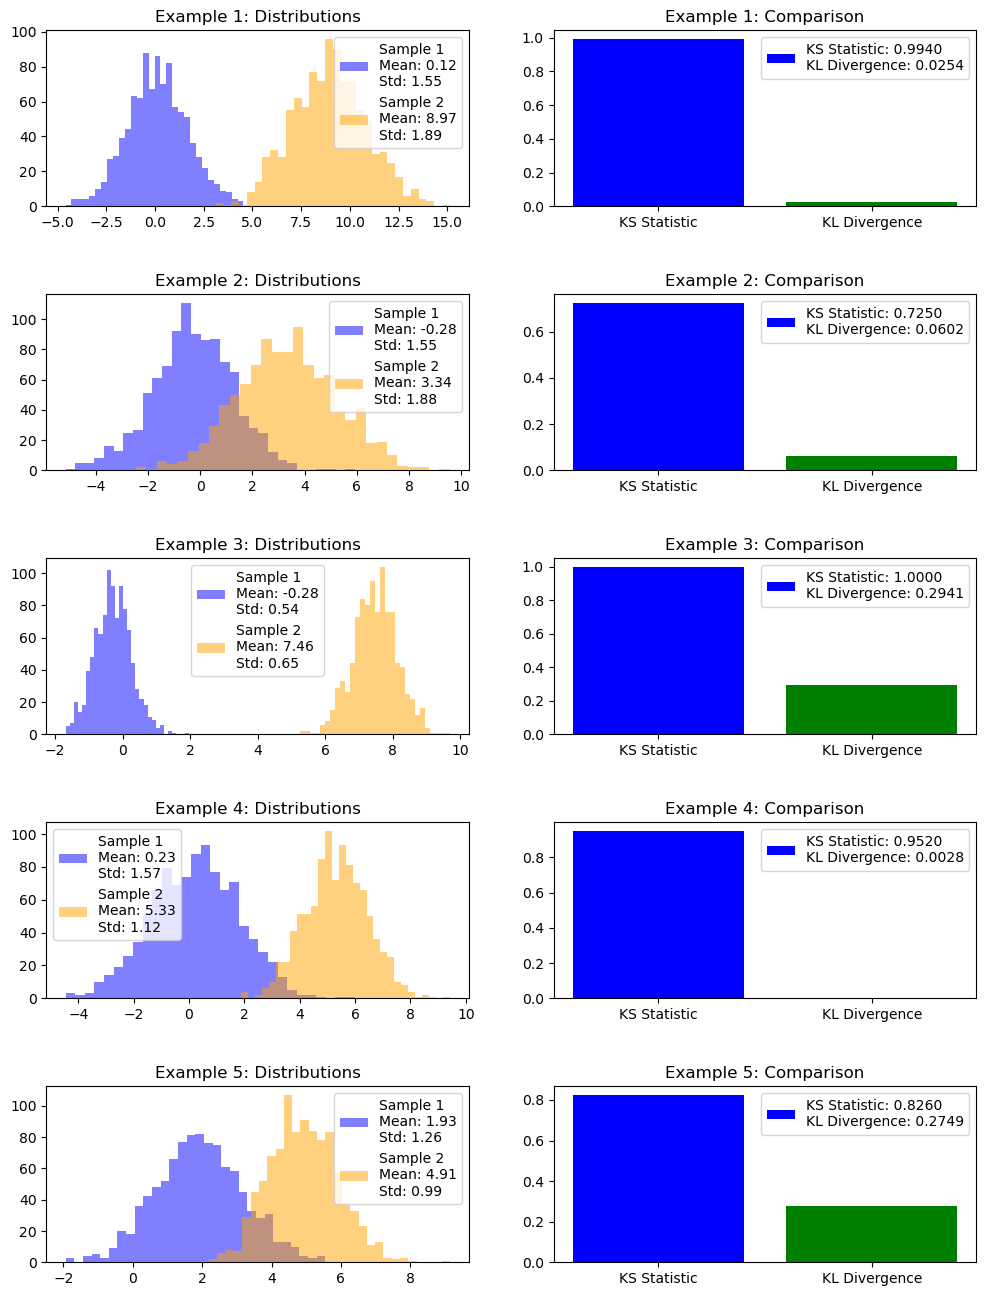

In [22]:
import numpy as np
from scipy.stats import ks_2samp
from scipy.stats import entropy
import matplotlib.pyplot as plt

# Number of examples
num_examples = 5

# Create a figure and axis for the plot
fig, axs = plt.subplots(num_examples, 2, figsize=(12, 16))
fig.subplots_adjust(hspace=0.5)

for example in range(num_examples):
    # Generate two sample datasets with different loc and scale parameters
    np.random.seed(example)
    loc1 = np.random.uniform(-2, 2)  # Random loc for sample1 between -1 and 1
    scale1 = np.random.uniform(0.5, 2)  # Random scale for sample1 between 0.5 and 2
    sample1 = np.random.normal(loc1, scale1, 1000)
    
    loc2 = np.random.uniform(1, 10)  # Random loc for sample2 between -1 and 1
    scale2 = np.random.uniform(0.5, 2)  # Random scale for sample2 between 0.5 and 2
    sample2 = np.random.normal(loc2, scale2, 1000)
    
    # Compute KS statistic and p-value
    ks_statistic, ks_p_value = ks_2samp(sample1, sample2)
    
    # Compute KL Divergence
    hist_sample1, _ = np.histogram(sample1, bins=10)
    hist_sample2, _ = np.histogram(sample2, bins=10)
    kl_divergence_value = entropy(hist_sample1, hist_sample2)
    
    # Plot the histograms of the two samples with mean and std in the legend
    legend_label = f'Sample 1\nMean: {np.mean(sample1):.2f}\nStd: {np.std(sample1):.2f}'
    legend_label_sample2 = f'Sample 2\nMean: {np.mean(sample2):.2f}\nStd: {np.std(sample2):.2f}'
    axs[example, 0].hist(sample1, bins=30, alpha=0.5, color='blue', label=legend_label)
    axs[example, 0].hist(sample2, bins=30, alpha=0.5, color='orange', label=legend_label_sample2)
    axs[example, 0].set_title(f'Example {example + 1}: Distributions')
    axs[example, 0].legend()
    
    # Plot KS Statistic and KL Divergence with labels in the legend
    axs[example, 1].bar(['KS Statistic', 'KL Divergence'], [ks_statistic, kl_divergence_value], color=['blue', 'green'])
    legend_label = f'KS Statistic: {ks_statistic:.4f}\nKL Divergence: {kl_divergence_value:.4f}'
    axs[example, 1].set_title(f'Example {example + 1}: Comparison')
    axs[example, 1].legend([legend_label])

plt.show()

- Khi 2 phân phối có khác biệt về giá trị trung bình thì KS sẽ khác nhau
- Còn khi khác biệt về dạng phân phối thì Entropy sẽ khác nhau

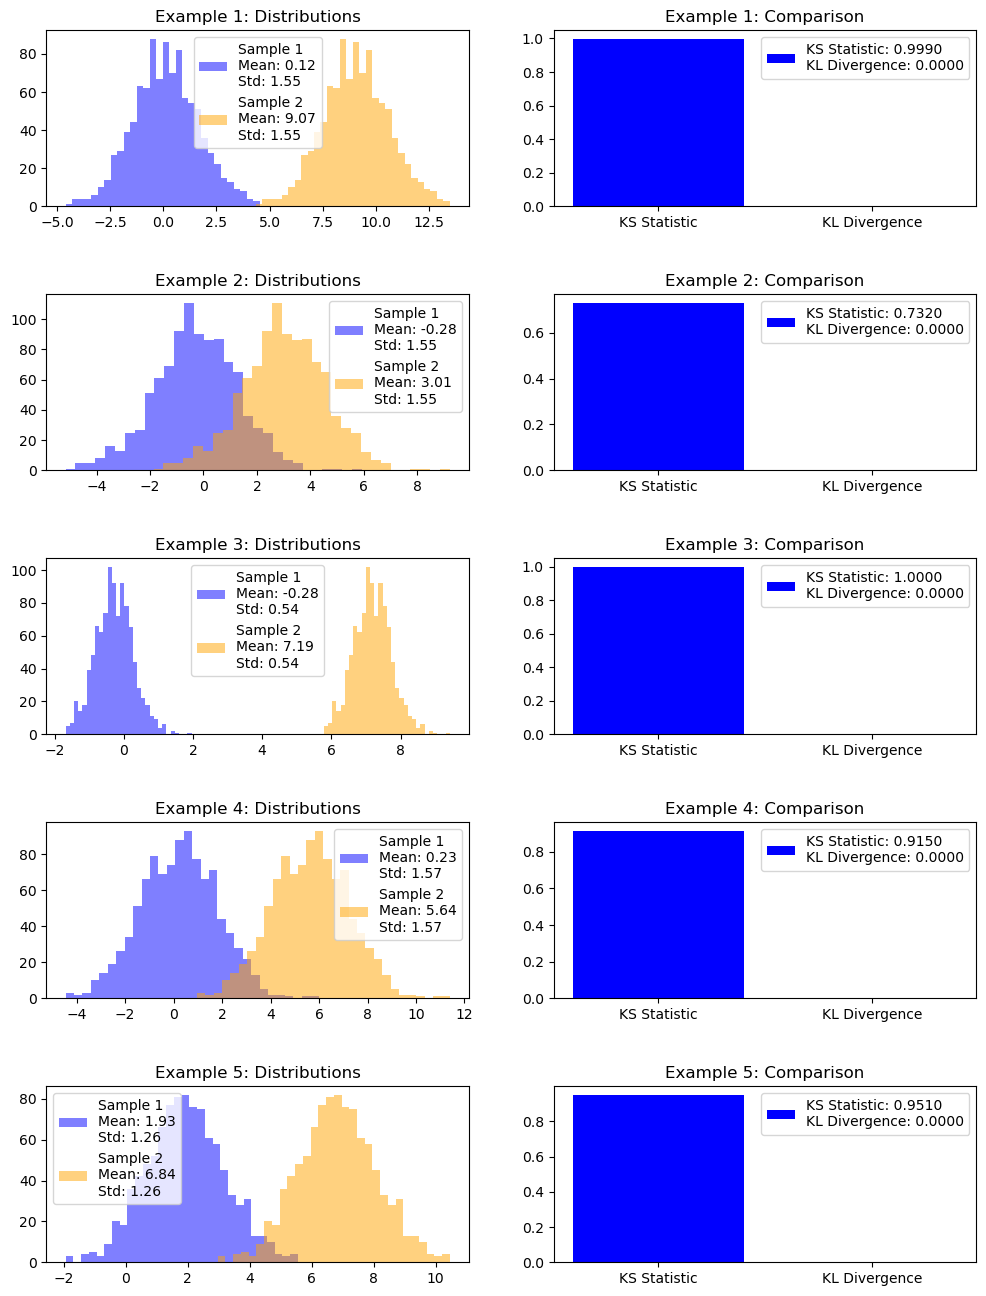

In [24]:
import numpy as np
from scipy.stats import ks_2samp
from scipy.stats import entropy
import matplotlib.pyplot as plt

# Number of examples
num_examples = 5

# Create a figure and axis for the plot
fig, axs = plt.subplots(num_examples, 2, figsize=(12, 16))
fig.subplots_adjust(hspace=0.5)

for example in range(num_examples):
    # Generate two sample datasets with different loc and scale parameters
    np.random.seed(example)
    loc1 = np.random.uniform(-2, 2)  # Random loc for sample1 between -1 and 1
    scale1 = np.random.uniform(0.5, 2)  # Random scale for sample1 between 0.5 and 2
    sample1 = np.random.normal(loc1, scale1, 1000)
    
    add_value = np.random.uniform(1, 10)  # Random loc for sample2 between -1 and 1    
    sample2 = sample1 + add_value
    
    # Compute KS statistic and p-value
    ks_statistic, ks_p_value = ks_2samp(sample1, sample2)
    
    # Compute KL Divergence
    hist_sample1, _ = np.histogram(sample1, bins=10)
    hist_sample2, _ = np.histogram(sample2, bins=10)
    kl_divergence_value = entropy(hist_sample1, hist_sample2)
    
    # Plot the histograms of the two samples with mean and std in the legend
    legend_label = f'Sample 1\nMean: {np.mean(sample1):.2f}\nStd: {np.std(sample1):.2f}'
    legend_label_sample2 = f'Sample 2\nMean: {np.mean(sample2):.2f}\nStd: {np.std(sample2):.2f}'
    axs[example, 0].hist(sample1, bins=30, alpha=0.5, color='blue', label=legend_label)
    axs[example, 0].hist(sample2, bins=30, alpha=0.5, color='orange', label=legend_label_sample2)
    axs[example, 0].set_title(f'Example {example + 1}: Distributions')
    axs[example, 0].legend()
    
    # Plot KS Statistic and KL Divergence with labels in the legend
    axs[example, 1].bar(['KS Statistic', 'KL Divergence'], [ks_statistic, kl_divergence_value], color=['blue', 'green'])
    legend_label = f'KS Statistic: {ks_statistic:.4f}\nKL Divergence: {kl_divergence_value:.4f}'
    axs[example, 1].set_title(f'Example {example + 1}: Comparison')
    axs[example, 1].legend([legend_label])

plt.show()

- Sử dụng 2 loại phân phối khác nhau, giá trị Entropy có sự khác biệt rõ rệt

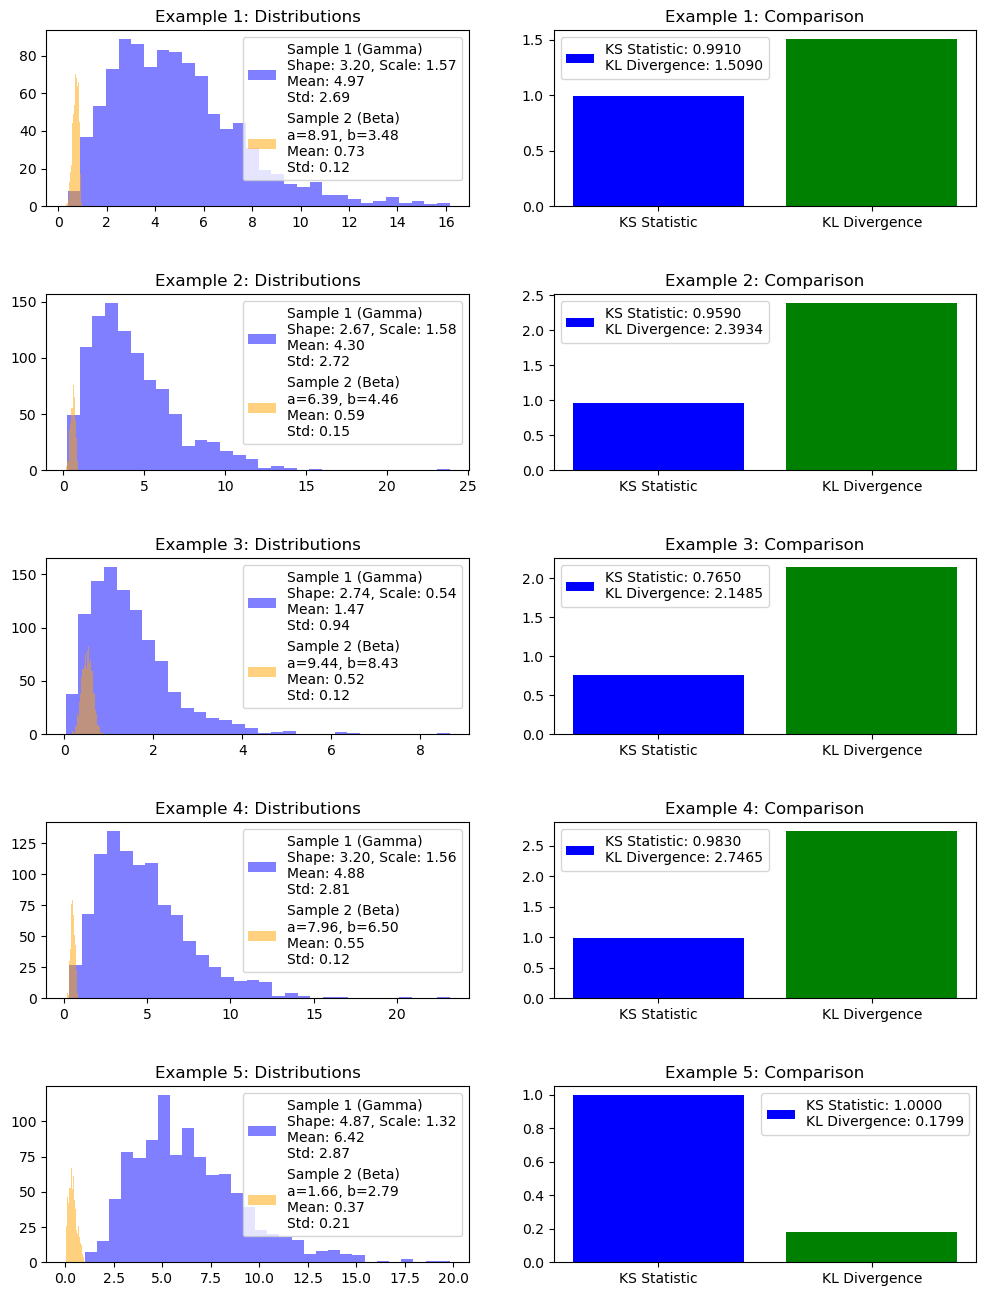

In [25]:
import numpy as np
from scipy.stats import ks_2samp, beta, gamma
from scipy.stats import entropy
import matplotlib.pyplot as plt

# Function to calculate KL Divergence
def kl_divergence(p, q):
    return entropy(p, q)

# Number of examples
num_examples = 5

# Create a figure and axis for the plot
fig, axs = plt.subplots(num_examples, 2, figsize=(12, 16))
fig.subplots_adjust(hspace=0.5)

for example in range(num_examples):
    # Generate two sample datasets with different loc and scale parameters
    np.random.seed(example)
    
    # Sample1 follows a gamma distribution
    shape1 = np.random.uniform(1, 5)  # Random shape parameter for gamma distribution
    scale1 = np.random.uniform(0.5, 2)  # Random scale parameter for gamma distribution
    sample1 = gamma.rvs(shape1, scale=scale1, size=1000)
    
    # Sample2 follows a beta distribution
    a2 = np.random.uniform(1, 10)  # Random shape parameter for beta distribution
    b2 = np.random.uniform(1, 10)  # Random scale parameter for beta distribution
    sample2 = beta.rvs(a2, b2, size=1000)
    
    # Compute KS statistic and p-value
    ks_statistic, ks_p_value = ks_2samp(sample1, sample2)
    
    # Compute KL Divergence
    hist_sample1, _ = np.histogram(sample1, bins=10)
    hist_sample2, _ = np.histogram(sample2, bins=10)
    kl_divergence_value = kl_divergence(hist_sample1, hist_sample2)
    
    # Plot the histograms of the two samples with mean and std in the legend
    legend_label_sample1 = f'Sample 1 (Gamma)\nShape: {shape1:.2f}, Scale: {scale1:.2f}\nMean: {np.mean(sample1):.2f}\nStd: {np.std(sample1):.2f}'
    legend_label_sample2 = f'Sample 2 (Beta)\na={a2:.2f}, b={b2:.2f}\nMean: {np.mean(sample2):.2f}\nStd: {np.std(sample2):.2f}'
    axs[example, 0].hist(sample1, bins=30, alpha=0.5, color='blue', label=legend_label_sample1)
    axs[example, 0].hist(sample2, bins=30, alpha=0.5, color='orange', label=legend_label_sample2)
    axs[example, 0].set_title(f'Example {example + 1}: Distributions')
    axs[example, 0].legend()
    
    # Plot KS Statistic and KL Divergence with labels in the legend
    axs[example, 1].bar(['KS Statistic', 'KL Divergence'], [ks_statistic, kl_divergence_value], color=['blue', 'green'])
    legend_label = f'KS Statistic: {ks_statistic:.4f}\nKL Divergence: {kl_divergence_value:.4f}'
    axs[example, 1].set_title(f'Example {example + 1}: Comparison')
    axs[example, 1].legend([legend_label])

plt.show()
